### The goal is to determine how repetitive each lyrics is

To determine how repetitive a song is, we will use Abraham Lempel and Jacob Ziv (LZ77) algorithm to identify repetitions in a piece of text. The algorithm finds and compresses parts of text that are the same. To obtain this information, we will first compress each file using GZIP - which uses DEFLATE, a combination of LZ77 and Huffman coding. Then we will use the program called infgen which provided statistics of a file compressed by gzip. We will use the statistics on compression to estimate how repetitive a song is, based on how much it was compressed. 

References: https://jvns.ca/blog/2015/02/22/how-gzip-uses-huffman-coding/
https://github.com/madler/infgen/blob/master/infgen.c
https://github.com/colinmorris/lalala

### On infgen usage

With the -s option, infgen will generate statistics comments, all of which
    begin with "! stats ".  There are statistics for each deflate block, and
    summary statistics after the last deflate block.  
    
    After the last deflate block, total statistics are output.  They all begin
    with "! stats total ".  The block input and output amounts are summed for
    example as: "! stats total inout 93232233:0 (55120762) 454563840", with the
    same format as "! stats inout", except without the reach.
    "! stats total block average 34162.3 uncompressed" states for example that
    the average number of uncompressed bytes per block was 34162.3.  Similarly
    "! stats total block average 4142.5 symbols" states that there were 4142.5
    symbols on average per block.  "! stats total literals 6.9 bits each"
    states that there were 6.9 bits used on average per literal.  Lastly the
    matches are summed: "! stats total matches 95.2% (33314520 x 13.0)" with
    the same format as "! stats matches".

In [52]:
import pandas as pd
import re
import os
from matplotlib import pyplot as plt
import numpy as np

In [2]:
lyrics = pd.read_csv('lyrics.nosync/final_matrix.csv')

In [3]:
lyrics.shape

(14157, 37)

In [4]:
lyrics.head()

,ARTIST,ISRC,SPOTIFY_ID,TITLE,lyrics,song_id,producer,number_of_tracks,number_of_albums,number_of_playlists,...,Metal,Other,Pop,R&B,Reggae,Rock/Alt,Rock/Alt/Pop,Singer-Songwriter,genre_missing,Explicit
0,Yo La Tengo,USMTD0985602,158mw0CsuSHxTVWpMwN2Lp,Avalon or Someone Very Similar,"\n\nAvalon, how did these things happen? Avalo...",1369717,['Roger Moutenot'],143,40,649,...,0,1,1,0,0,1,0,0,0,0
1,Yo La Tengo,USGKX9802104,7iX2vtYJlemPod7080OxTG,Swing For Life,"\n\nOh, true rider, fasten me\nI saw a mystery...",1063052,[],143,40,649,...,0,1,1,0,0,1,0,0,0,0
2,Yo La Tengo,USMTD1810576,2YmjVaikl30rmZZzlGTwPE,Ashes,"\n\nI put spots on a bird of paradise, snake e...",3596137,['Yo La Tengo'],143,40,649,...,0,1,1,0,0,1,0,0,0,0
3,Smrtdeath,QZANL1773974,4sBj3qUIPBkIMcRVlh6iXI,Let It Bleed,"\n\n[Intro]\nSethany, Sethany, Sethany\nYeah, ...",3150542,['Taxpurposes'],10,10,30,...,0,0,0,0,0,0,0,0,0,1
4,Smrtdeath,QZANL1773973,3gjrflTTriqZ9d30uSF4hP,Went & Got Some More,"\n\n[Hook: Smrtdeath]\nI just lost some drugs,...",3256462,"['Eternal Night', 'Sorry If I Waste Your Time']",10,10,30,...,0,0,0,0,0,0,0,0,0,1


In [6]:
test = lyrics['lyrics'][5].split('\n')

In [7]:
with open('test_file.txt', 'w') as f:
    for item in test:
        f.write("%s\n" % item)

In [8]:
for i,j in lyrics.iterrows():
    print(j['lyrics'])
    print(j['song_id'])
    break



Avalon, how did these things happen? Avalon, tell me all you know
The perfect crime we laughed about it, laughed the whole night through
When we were caught, it was because of you

Talking about all that we once knew

Avalon, the clock is falling back now, Avalon, we'd be if we could
You used to say "the water's fine, nevermind the view"
I didn't mind as long as I have you

Talking about all that we've been through

Somedays, somedays we might be tired of being tired
We claim, we claim to be one of one of one

We didn't know the things we said, would turn out untrue
The day would come when I'd be somewhere new and what about you
Times have changed for me and times have changed for you, for you

Talking about all that we once knew


1369717


In [6]:
#Convert each lyrics to a separate text file
for index, row in lyrics.iterrows():
    lyrics_data = row.lyrics
    song_id = row.song_id

    with open('working_files/'+str(song_id)+'.txt', 'w') as f:
        f.write(lyrics_data)

In [10]:
# Zip every txt file in the current folder
! gzip working_files/ -r *.txt 

gzip: can't stat: *.txt (*.txt): No such file or directory


In [14]:
! for filename in /working_files/*.txt; do
!        ./infgen -s $filename > $filename.txt 
!    done

/bin/sh: -c: line 1: syntax error: unexpected end of file

infgen 2.4
Usage:

  infgen [-dq[q]isrb] input_path > output_path
  infgen [-dq[q]isrb] < input_path > output_path

    -d   Write raw dynamic header (code lengths in comments)
    -q   Do not write dynamic code lengths (comments or not)
    -qq  Do not write deflate stream description at all
    -i   Include detailed gzip / zlib header descriptions
    -s   Include deflate block statistics (as comments)
    -r   Assume raw deflate data -- do not look for headers
    -b   Write compact binary format (only -r honored)

/bin/sh: -c: line 0: syntax error near unexpected token `done'
/bin/sh: -c: line 0: `    done'


In [11]:
# Extract infgen data about compression from each file
! ./infgen -s *.txt.gz > *.txt

infgen error: only one input file permitted (*.txt.gz)


In [23]:
# Find all files outputed by infgen
out_files = [f for f in os.listdir('output_files/') if f.endswith('.txt')]

In [31]:
out_files[0]

'3462015.txt.gz.txt'

In [209]:
# Find compression ratios
ids = []
compression_ratios = []

for file in out_files:
    ratio = ratio_by_file(file)
    compression_ratios.append(ratio)
    file_id = file.split('.')[0]
    ids.append(file_id)

In [210]:
ratio_by_file = pd.DataFrame()
ratio_by_file['song_id'] = ids
ratio_by_file['repetition_share'] = compression_ratios

In [211]:
ratio_by_file.shape

(14157, 2)

In [212]:
ratio_by_file.head()

,song_id,repetition_share
0,3462015,0.446273
1,821682,0.326169
2,1384829,0.221843
3,1586903,0.420432
4,942185,0.129151


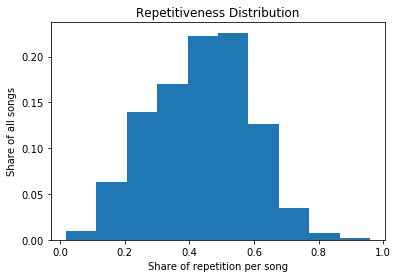

In [228]:
weights = np.ones_like(ratio_by_file.repetition_share)/float(len(ratio_by_file.repetition_share))
plt.hist(ratio_by_file.repetition_share, 10, weights=weights)
plt.title('Repetitiveness Distribution')
plt.xlabel('Share of repetition per song')
plt.ylabel('Share of all songs')
plt.show()

In [229]:
ratio_by_file['song_id'] = ratio_by_file.song_id.map(lambda x: int(x))

In [230]:
merged = lyrics.merge(ratio_by_file, how='inner', on='song_id')

In [231]:
merged.shape


(14157, 38)

### More popular songs are more repetitive

In [174]:
from scipy.stats import pointbiserialr

In [177]:
pointbiserialr(merged.log_repetitiveness, merged.Metal)

PointbiserialrResult(correlation=-0.13100763025415227, pvalue=3.1278326381167285e-55)

In [233]:
cors = merged.corr()['repetition_share'].sort_values(ascending=False)
cors

repetition_share           1.000000
song_id                    0.270345
max_popularity             0.266698
highest_song_popularity    0.202580
average_song_popularity    0.201805
Dance/Electro              0.140254
Pop                        0.136368
playlist_followers         0.136303
number_of_playlists        0.126005
B_Level Artist?            0.092515
number_of_albums           0.053980
Christian/Gospel           0.053068
R&B                        0.044546
Dutch-House                0.035792
Reggae                     0.033090
Rock/Alt/Pop               0.016808
Blues                      0.004228
genre_missing              0.003130
Disco                      0.001330
Latin                     -0.001325
Indie                     -0.005218
Hip-Hop                   -0.018805
number_of_tracks          -0.021459
Explicit                  -0.032925
Country                   -0.037322
Singer-Songwriter         -0.045894
Jazz                      -0.047856
Folk                      -0

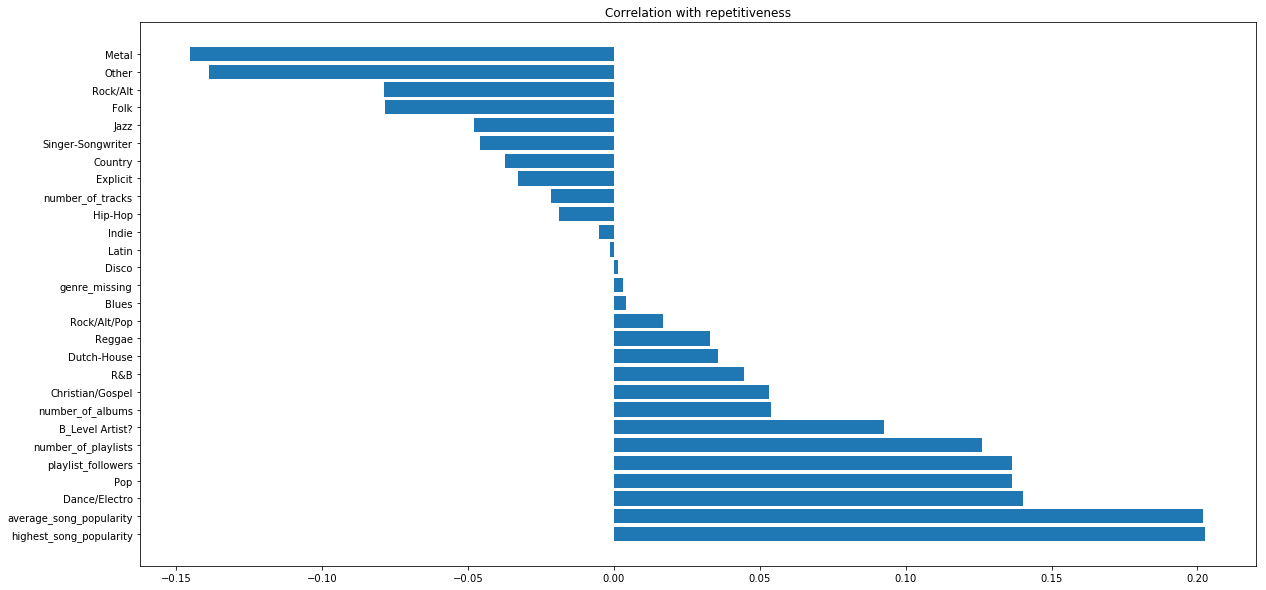

In [234]:
plt.figure(figsize=(20,10))
plt.barh(np.arange(28), cors.values[3:-1])
plt.yticks(np.arange(28), cors.index[3:-1])
plt.title('Correlation with repetitiveness')
plt.show()

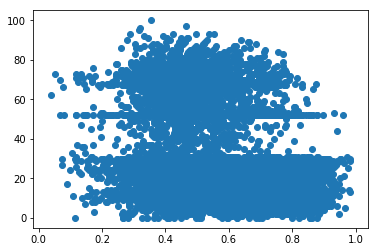

In [201]:
plt.scatter(merged.repetitiveness, merged.max_popularity)
plt.show()

In [202]:
genres = ['Blues', 'Christian/Gospel', 'Country',
       'Dance/Electro', 'Disco', 'Dutch-House', 'Folk', 'Hip-Hop', 'Indie',
       'Jazz', 'Latin', 'Metal', 'Other', 'Pop', 'R&B', 'Reggae', 'Rock/Alt',
       'Rock/Alt/Pop', 'Singer-Songwriter', 'genre_missing']

In [235]:
repetitiveness_by_genre = {}

for genre in genres:
    r = merged[merged[genre]==1]['repetition_share'].mean()
    repetitiveness_by_genre[genre] = r

In [236]:
repetitiveness_by_genre

{'Blues': 0.44248313251560273,
 'Christian/Gospel': 0.5025435261000623,
 'Country': 0.41244454136996844,
 'Dance/Electro': 0.48877246779202455,
 'Disco': 0.4380148503520831,
 'Dutch-House': 0.5879659656823173,
 'Folk': 0.3979916651406296,
 'Hip-Hop': 0.4297920747022033,
 'Indie': 0.4338785620411465,
 'Jazz': 0.3853740586181462,
 'Latin': 0.4332349364104605,
 'Metal': 0.36923309825735773,
 'Other': 0.41383738355846705,
 'Pop': 0.4681644354109963,
 'R&B': 0.46159279734590875,
 'Reggae': 0.4774276459323759,
 'Rock/Alt': 0.41710923125418753,
 'Rock/Alt/Pop': 0.48116311536205986,
 'Singer-Songwriter': 0.39784282323186615,
 'genre_missing': 0.43716719233558526}

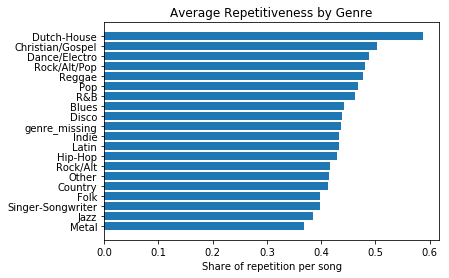

In [251]:
sort_idx = np.argsort(list(repetitiveness_by_genre.values()))
sorted_rep = [list(repetitiveness_by_genre.values())[x] for x in sort_idx]
sorted_lab = [list(repetitiveness_by_genre.keys())[x] for x in sort_idx]

plt.barh(np.arange(len(repetitiveness_by_genre)),sorted_rep)
plt.yticks(np.arange(len(repetitiveness_by_genre)),sorted_lab)
plt.title('Average Repetitiveness by Genre')
plt.xlabel('Share of repetition per song')
plt.show()

In [239]:
# Most repetitive song
merged[merged.repetition_share == merged.repetition_share.max()]

,ARTIST,ISRC,SPOTIFY_ID,TITLE,lyrics,song_id,producer,number_of_tracks,number_of_albums,number_of_playlists,...,Other,Pop,R&B,Reggae,Rock/Alt,Rock/Alt/Pop,Singer-Songwriter,genre_missing,Explicit,repetition_share
10659,Marshmello,TCADR1850743,1LwVrOwwPJPU5lVuQDPnGA,Check This Out,"\n\n[Hook]\nCheck this, check this, check this...",3778365,['Marshmello'],51,49,5930,...,0,1,0,0,0,0,0,0,0,0.959667


In [240]:
# Least repetitive song
merged[merged.repetition_share == merged.repetition_share.min()]

,ARTIST,ISRC,SPOTIFY_ID,TITLE,lyrics,song_id,producer,number_of_tracks,number_of_albums,number_of_playlists,...,Other,Pop,R&B,Reggae,Rock/Alt,Rock/Alt/Pop,Singer-Songwriter,genre_missing,Explicit,repetition_share
2778,Tragic Hero,TCADO1861238,7HCllfKMkkRS15S6ZBBVJQ,White Bronco,\n\n[Verse:]\nI got some real ones saying take...,3623907,['Weathrman'],15,12,16,...,1,0,0,0,0,0,0,0,0,0.017361


In [70]:
import os

for i in gz_files:
    print("Processing:", i)
    cmd = './infgen -s {file} > {file}-infgen-out.txt'.format(file=i)
    print('Running command: ' + cmd)
    os.system(cmd)

Processing: 1760739.txt.gz
Running command: ./infgen -s 1760739.txt.gz > 1760739.txt.gz-infgen-out.txt


In [47]:
! ./infgen -s "1760739.txt.gz" > hey.txt

In [206]:
def parse_ratio(f):
    '''Determine the compression ratio as a proxy of song repetitiveness'''
    matches = 0
    n_literals = 0
    n_symbols = 0
    uncomp = 0
    
    for line in f:
        if line.startswith('match'):
            _, length, dist = line.split()
            matches += 1

        pattern = r'! stats literals \d\.\d bits each \(\d+/(\d+)\)'
        p = re.compile(pattern)
        m = re.match(p, line)
        if m:
            n_literals = int(m.group(1))

        m = re.match(r'! stats total inout \d+:\d+ \((\d+)\)', line)
        if m:
            n_symbols = int(m.group(1))

        m = re.match(r'! stats total block average (\d+)\.\d uncompressed', line)
        if m:
            uncomp = int(m.group(1))

    assert matches + n_literals == n_symbols

    # 1 byte per literal, 3 bytes per match.
    pseudosize = matches * 3 + n_literals
    ratio = 1 - pseudosize / uncomp

    return ratio

In [208]:
def ratio_by_file(filename):
    '''Read in file and return compression ratio'''
    
    df = pd.read_table('output_files/' + filename)
    df.columns = ['infgen']
    inp = df.infgen.tolist()
    
    ratio = parse_ratio(inp)
    
    return ratio
    